# **Case Study**


## **Question 1 ：For each policy, Lim should determine the class for each arriving pallet and each departing pallet so that the total travel distance in week 17 was minimised. She use the actual demands in Exhibit 2 to evaluate each policy**

Steps for Question 1：
1. calculate flow rate to select Top 10 product

2. Assign top 10 product to class
> 2.1 partitioning warehouse into 4 classes beased on  inbound and outbound distance frequency of sections (Done)  

 > 2.2 Calculate the distance from class to in-door and out-door

 > 2.3 Estimate the minimum initial inventory for Top 10 prodcut

 > 2.4 Assign Top 10 product into class based on each policy; and calculate total travel distance for each policy （LPM,TOD,TOS） 

     > (1) LPM 

    >(2)TOS

    >(3)TOD





**Answer**
1. For LPM policy, the optimal total travel distance in week 17 is 36016.04.
2. For TOS policy, based on our assigning rule, the total travel distance in week 17 is 22764.79.
3. For TOD policy, we have finished calculating the turnover rate for week 17and have also written a class assigning rule for the product as part of our TOD policy. The only pending task is to write the code.

### **Step 1- Calculate flow rate to select Top 10 product**

I calculate the flow amount for the first 16 weeks to pick up the top 10 product (we need to predict later) that has the largest flow amount. And use these 10 products to forecast the optimized distance.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


In [3]:
#load two sheets seperatly
#load the first sheet, and add column names
df_inbound = pd.read_excel('C:/Users/26741/BAX424/HW1/SMU566-XLS-ENG(2).xlsx',sheet_name='Inbound', header=None, names=['day', 'product', 'inbound'])

# Load the second sheet of the Excel file as outbound
df_outbound = pd.read_excel('C:/Users/26741/BAX424/HW1/SMU566-XLS-ENG(2).xlsx',sheet_name='Outbound', header=None, names=['day', 'product', 'outbound'])

In [4]:
#look at the first 16 weeks data first
#df_inbound = df_inbound[df_inbound['day'] <= 16*6]
#df_outbound = df_outbound[df_outbound['day'] <= 16*6]
df_outbound

,day,product,outbound
0,1,3,10
1,1,7,10
2,1,9,1
3,1,12,4
4,1,14,4
...,...,...,...
2341,307,13,2
2342,307,14,1
2343,307,15,1
2344,307,16,2


In [5]:
#Then merge two xlsx files using outer join on 'day' and 'product'
df_merged = pd.merge(df_inbound, df_outbound, on=['day', 'product'], how='outer')

# Fill NaN values with 0
df_merged.fillna(0, inplace=True)

# Sort the merged dataframe by 'day' and 'product'
df_merged.sort_values(['day', 'product'], inplace=True)

# Reset the index
df_merged.reset_index(drop=True, inplace=True)

# group the data by day and product, and calculate the sum of inbound and outbound amounts
df_flow = df_merged.groupby(['day', 'product'])['inbound', 'outbound'].sum()

# calculate the flow amount by adding inbound and outbound amounts
df_flow['flow_amount'] = df_flow['inbound'] + df_flow['outbound']

# filter the data for the first 16 weeks
df_flow_16weeks = df_flow[df_flow.index.get_level_values('day') <= 96]

# calculate the average flow amount for each product and sort by descending order
df_ranked = df_flow_16weeks.groupby('product')['flow_amount'].sum().sort_values(ascending=False)
df_ranked.head(10)


C:\Users\26741\AppData\Local\Temp/ipykernel_17364/2028572246.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_flow = df_merged.groupby(['day', 'product'])['inbound', 'outbound'].sum()


product
1     3315.0
3     1423.0
2     1339.0
4     1271.0
9     1106.0
5     1030.0
7     1015.0
10     968.0
11     919.0
12     904.0
Name: flow_amount, dtype: float64

Here, we can see the top 10 flow amount products are 1,3,2,4,9,5,7,10,11,12

In [6]:
products_to_select = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]
filtered_data = df_merged[df_merged['product'].isin(products_to_select)]
#filtered_data.head(30)

In [7]:
#for question 1: we need all 17th weeks' data, which is from (6*16+1) to (17*6)
df_flow_17th_week = filtered_data[(filtered_data['day'] <= 17*6) & ( filtered_data['day'] > 16*6)]
#df_flow_17th_week = filtered_data[filtered_data['day'] > 16*6]
df_flow_17th_week


,day,product,inbound,outbound
898,97,1,0.0,160.0
899,97,2,4.0,28.0
900,97,3,0.0,32.0
901,97,4,24.0,0.0
902,97,5,0.0,24.0
905,97,9,63.0,0.0
911,98,1,54.0,0.0
912,98,2,18.0,0.0
913,98,5,36.0,4.0
914,98,7,0.0,3.0


### **Step 2 - Assign top 10 product to class**

#### **2.1 partitioning warehouse into 4 classes beased on inbound and outbound distance frequency of each section**



In [8]:
#set the coordinate for in_door and out_door
in_door = (0,37)
out_door = (2,0)

In [9]:
#set a array to collect all space that forklift need to move to
spaces = []
for row in range(1,48):
    if row % 5 != 0:
        continue
    for col in range(0, 54):
        if col < 4 or col > 51:
            continue
  
        x = col
        #even rows are 1,3,5,7,9,11,13,15,17, they are located in 4th,9th,14th,19th,24th,29th,34th,39th and 44th row.
        #therefore the forklift should move to 3rd,8th,13th,18th,23rd,28th,33rd,38th and 43rd row which are the numbers dividable by 5 minus 2 in range (0,48).
        #the same way, odd rows are located in 5 dividable rows and the forklift should move to rows+1 th row.
        y_even = row+1
        y_odd = row-2 
        
        spaces.append((x, y_odd))
        spaces.append((x, y_even))

In [10]:
#calculate the distance that forklift need to move to 
distances = []
for space in spaces:
    #the warehouse is a 73.125*65 meters rectangle and is divided into 54*48 small rectancles
    #therefore the length of each small rectancle is (73.125/54) and wide is (65/48) 
    dist_to_in_door = abs(space[0] - in_door[0])*(73.125/54) + abs(space[1] - in_door[1])*(65/48)
    dist_to_out_door = abs(space[0] - out_door[0])*(73.125/54) + abs(space[1] - out_door[1])*(65/48)
    total_dist = dist_to_in_door + dist_to_out_door
    distances.append((space, total_dist))

#sort the distance 
distances.sort(key=lambda x: x[1])

#and then divide it into 4 classes by percentile
dist_values = [x[1] for x in distances]
quartiles = np.percentile(dist_values, [25, 50, 75])
class1 = [x[0] for x in distances if x[1] <= quartiles[0]]
class2 = [x[0] for x in distances if quartiles[0] < x[1] <= quartiles[1]]
class3 = [x[0] for x in distances if quartiles[1] < x[1] <= quartiles[2]]
class4 = [x[0] for x in distances if x[1] > quartiles[2]]

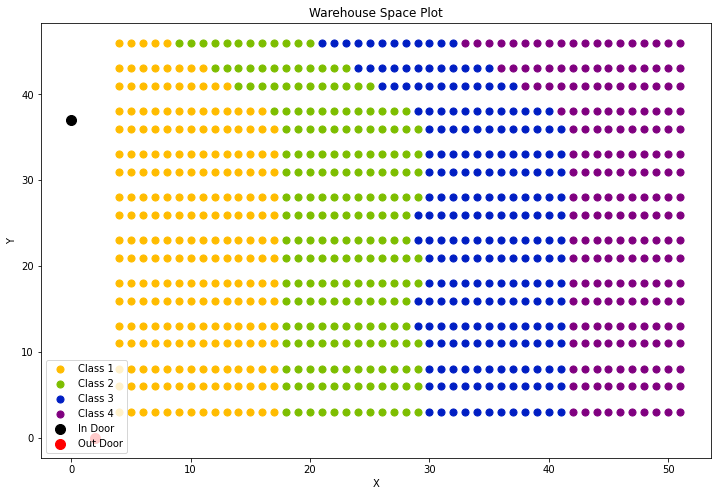

In [11]:
# define the colors for the classes using gradient green
cmap = colors.LinearSegmentedColormap.from_list("", ["red", "orange", "yellow", "green", "blue", "purple"])

# create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# plot the spaces
ax.scatter([space[0] for space in class1], [space[1] for space in class1], color=cmap(0.25), label='Class 1', s=50)
ax.scatter([space[0] for space in class2], [space[1] for space in class2], color=cmap(0.50), label='Class 2', s=50)
ax.scatter([space[0] for space in class3], [space[1] for space in class3], color=cmap(0.75), label='Class 3', s=50)
ax.scatter([space[0] for space in class4], [space[1] for space in class4], color=cmap(1.0), label='Class 4', s=50)

# plot the in_door and out_door
ax.scatter(in_door[0], in_door[1], color='black', label='In Door', s=100)
ax.scatter(out_door[0], out_door[1], color='red', label='Out Door', s=100)

# set the title and labels
ax.set_title('Warehouse Space Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# add the legend
ax.legend()

#### **2.2 Calculate the distance from class to in-door and out-door**

we use average distance to estimate s_j & r_j for each class

In [12]:
# calculate average distance to in_door and out_door for each class
class_distances = [class1, class2, class3, class4]

avg_distances = np.zeros((4, 2))  # create a matrix of zeros with shape (4, 2)

for i in range(4):
    distances = class_distances[i]
    total_dist_in = 0
    total_dist_out = 0
    for space in distances:
        dist_to_in_door = abs(space[0] - in_door[0])*(73.125/54) + abs(space[1] - in_door[1])*(65/48)
        dist_to_out_door = abs(space[0] - out_door[0])*(73.125/54) + abs(space[1] - out_door[1])*(65/48)
        total_dist_in += dist_to_in_door
        total_dist_out += dist_to_out_door
    avg_dist_in = total_dist_in / len(distances)
    avg_dist_out = total_dist_out / len(distances)
    avg_distances[i, 0] = avg_dist_in  # assign the average distances to the matrix
    avg_distances[i, 1] = avg_dist_out

print(avg_distances)

[[34.66549928 42.02002514]
 [50.01474057 60.74587264]
 [66.44034091 76.78125   ]
 [80.68802083 94.90677083]]


In [13]:
# extract the first column as s
# extract the second column as r
s_j = avg_distances[:, 0]
r_j = avg_distances[:, 1]
# print s_j
print(s_j)
print(r_j)

[34.66549928 50.01474057 66.44034091 80.68802083]
[42.02002514 60.74587264 76.78125    94.90677083]


 
 #### **2.3 Estimate the minimum initial inventory for Top 10 prodcut**


To calculate the minimum initial inventory for Top 10 product in Day 1 to ensure that it has enough outbound for each day, we can follow these steps:

1.   Calculate the cumulative inbound and outbound for each product and day.
2.   Calculate the difference between cumulative inbound and outbound for each   product and day.
3. Find the minimum difference for each product.
4. If the minimum difference is negative, its absolute value represents the minimum initial inventory required for that product



In [14]:
#Then merge two xlsx files using outer join on 'day' and 'product'
df_merged = pd.merge(df_inbound, df_outbound, on=['day', 'product'], how='outer')

# Fill NaN values with 0
df_merged.fillna(0, inplace=True)

# Sort the merged dataframe by 'day' and 'product'
df_merged.sort_values(['day', 'product'], inplace=True)

# Reset the index
df_merged.reset_index(drop=True, inplace=True)

In [15]:
# List of desired products
desired_products = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]

# Filter the DataFrame to include only rows with day <= 96 and the desired products, then create a new DataFrame
df_filtered = df_merged[(df_merged['product'].isin(desired_products))].copy()

# Calculate the cumulative sum of inbound and outbound for each product
df_filtered['cum_inbound'] = df_filtered.groupby('product')['inbound'].cumsum()
df_filtered['cum_outbound'] = df_filtered.groupby('product')['outbound'].cumsum()

# Calculate the difference between cumulative inbound and outbound
df_filtered['difference'] = df_filtered['cum_inbound'] - df_filtered['cum_outbound']

# Find the minimum difference for each product
min_difference = df_filtered.groupby('product')['difference'].min().reset_index()

# If the minimum difference is negative, take its absolute value as the minimum initial inventory required
min_difference['min_initial_inventory'] = min_difference['difference'].apply(lambda x: abs(x) if x < 0 else 0)

print(min_difference[['product', 'min_initial_inventory']])

   product  min_initial_inventory
0        1                  115.0
1        2                  188.0
2        3                 4035.0
3        4                    0.0
4        5                  245.0
5        7                 3022.0
6        9                    0.0
7       10                 2590.0
8       11                    0.0
9       12                 2657.0


#### **2.4 Assign Top 10 product into class based on each policy; and calculate total travel distance for each policy （LPM,TOD,TOS）**



**2.4.1 Calculate the inbound and outbound flow for Top 10 product of 17th_week**

In [16]:
#Then merge two xlsx files using outer join on 'day' and 'product'
df_merged = pd.merge(df_inbound, df_outbound, on=['day', 'product'], how='outer')

# Fill NaN values with 0
df_merged.fillna(0, inplace=True)

# Sort the merged dataframe by 'day' and 'product'
df_merged.sort_values(['day', 'product'], inplace=True)

# Reset the index
df_merged.reset_index(drop=True, inplace=True)

# List of desired products
desired_products = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]
week_17th = [97,98,99,100,101,102]

# Filter the DataFrame to include only rows in week 17 and the desired products, then create a new DataFrame
df_flow_17th_week = df_merged[(df_merged['day'].isin(week_17th)) & (df_merged['product'].isin(desired_products))].copy()

df_flow_17th_week

,day,product,inbound,outbound
898,97,1,0.0,160.0
899,97,2,4.0,28.0
900,97,3,0.0,32.0
901,97,4,24.0,0.0
902,97,5,0.0,24.0
905,97,9,63.0,0.0
911,98,1,54.0,0.0
912,98,2,18.0,0.0
913,98,5,36.0,4.0
914,98,7,0.0,3.0


**2.4.2 Calculate variable" a_it " and "d_it" for Top 10 product**

In [17]:
# Get the unique days in the dataframe
#days = df_inbound['day'].unique()

# Create an empty numpy array to store the values of a_it
a_it = np.zeros((20, 7))
d_it = np.zeros((20, 7))

# Loop through each product and day and get the corresponding value of a_it
for i in range(20):
    for t in range(7):
        day = t + 96
        if i in df_flow_17th_week['product'].values:
            inbound_values = df_flow_17th_week.loc[(df_flow_17th_week['product'] == i) & (df_flow_17th_week['day'] == day), 'inbound'].values
            if len(inbound_values) > 0:
                a_it[i][t] = inbound_values[0]
            else:
                a_it[i][t] = 0
        else:
            a_it[i][t] = 0
        

for i in range(20):
    for t in range(7):
        day = t + 96
        if i in df_flow_17th_week['product'].values:
            outbound_values = df_flow_17th_week.loc[(df_flow_17th_week['product'] == i) & (df_flow_17th_week['day'] == day), 'outbound'].values
            if len(outbound_values) > 0:
                d_it[i][t] = outbound_values[0]
            else:
                d_it[i][t] = 0
        else:
            d_it[i][t] = 0

**2.4.3 LPM Policy**

**For LPM policy, the optimal total travel distance in week 17 is 36016.04**.


> for detailed calculation please see the code shown as below:



In [18]:
!pip install pulp
import pulp

#M = products_to_select
N = 4
M = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]
T = [97, 98, 99, 100, 101, 102]

# capacity c
c_j = [1068, 964, 1004, 900]

# Define the problem
problem = pulp.LpProblem("Warehouse_Optimization", pulp.LpMinimize)

# Define decision variables
v = pulp.LpVariable.dicts("v", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
w = pulp.LpVariable.dicts("w", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
x = pulp.LpVariable.dicts("x", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")

# Define objective function
problem += pulp.lpSum(s_j[j] * v[i, j, t] + r_j[j] * w[i, j, t] for i in M for j in range(N) for t in T)

# Add constraints
for i in M:
    for t in T:
        problem += pulp.lpSum(v[i, j, t] for j in range(N)) == a_it[i][t-97]  # constraint 1
        problem += pulp.lpSum(w[i, j, t] for j in range(N)) == d_it[i][t-97]  # constraint 2

for i in M:
    for j in range(N):
        for t in T[:-1]:
            problem += v[i, j, t] - w[i, j, t] + x[i, j, t] == x[i, j, t + 1]  # constraint 3

for j in range(N):
    for t in T:
        problem += pulp.lpSum(x[i, j, t] + v[i, j, t] for i in M) <= c_j[j]  # constraint 4

# Solve the problem
problem.solve()

# Print the results
print("Status:", pulp.LpStatus[problem.status])
print("Optimal Solution:", pulp.value(problem.objective))

# Print decision variables
for variable in problem.variables():
    if variable.varValue > 0:
        print(variable.name, "=", variable.varValue)

Status: Optimal
Optimal Solution: 36016.04121767242
v_(1,_0,_100) = 19.0
v_(1,_0,_101) = 18.0
v_(1,_0,_102) = 72.0
v_(1,_0,_99) = 54.0
v_(2,_0,_98) = 4.0
v_(2,_0,_99) = 18.0
v_(4,_0,_98) = 24.0
v_(5,_0,_102) = 19.0
v_(5,_0,_99) = 36.0
v_(9,_0,_102) = 38.0
v_(9,_0,_98) = 63.0
w_(1,_0,_102) = 4.0
w_(1,_0,_98) = 160.0
w_(10,_0,_100) = 68.0
w_(10,_0,_99) = 104.0
w_(11,_0,_99) = 2.0
w_(12,_0,_101) = 47.0
w_(2,_0,_101) = 7.0
w_(2,_0,_98) = 28.0
w_(3,_0,_100) = 2.0
w_(3,_0,_101) = 18.0
w_(3,_0,_98) = 32.0
w_(5,_0,_101) = 9.0
w_(5,_0,_102) = 10.0
w_(5,_0,_98) = 24.0
w_(5,_0,_99) = 4.0
w_(7,_0,_101) = 4.0
w_(7,_0,_102) = 28.0
w_(7,_0,_99) = 3.0
w_(9,_0,_102) = 2.0
x_(1,_0,_100) = 54.0
x_(1,_0,_101) = 73.0
x_(1,_0,_102) = 91.0
x_(1,_0,_97) = 160.0
x_(1,_0,_98) = 160.0
x_(10,_0,_100) = 68.0
x_(10,_0,_97) = 172.0
x_(10,_0,_98) = 172.0
x_(10,_0,_99) = 172.0
x_(11,_0,_97) = 2.0
x_(11,_0,_98) = 2.0
x_(11,_0,_99) = 2.0
x_(12,_0,_100) = 47.0
x_(12,_0,_101) = 47.0
x_(12,_0,_97) = 47.0
x_(12,_0,_98) = 47

Note: explaination for the result:v_(product id,class No., Day) & w_(product id,class No., Day) ; and Class No. = [0,1,2,3] represent [class1,class2,class3,class4]; v_(1,_0,_100) means the arrivals of product 1 in Day 100 is assigned to class 1. 

## **Question 2 ：Following the moving-average forecasting method, repeat Question (1) for each ofthe remaining weeks (week 18 to week 52). Which policy gives the smallest average weekly travel distance?**

**Answer**

based on up to date  calculation, **LPM gives the smallest average weekly travel distance.**


1. Average weekly travel distance for LPM policy is 60791.48
2. Average weekly travel distance for TOS policy is 24017.990733906663
3. for TOD policy, we have also written a class assigning rule in Question 1(step2-2.4.5. TOD Policy). The only pending task is to write the code.

#### **2.1 LPM Policy**

**Result : Average weekly travel distance for LPM policy is 60791.48** 

Detailed calculation is shown as below:

In [19]:
df_merged_desired = df_merged[df_merged['product'].isin(desired_products)]
df_merged_desired_16weeks = df_merged_desired[df_merged_desired['day']<=96]
df_merged_desired_16weeks

,day,product,inbound,outbound
0,1,1,18.0,0.0
1,1,3,0.0,10.0
2,1,4,1.0,0.0
3,1,5,55.0,0.0
4,1,7,17.0,10.0
...,...,...,...,...
888,96,3,0.0,72.0
889,96,4,70.0,0.0
890,96,5,0.0,17.0
892,96,9,0.0,1.0


 - we use moving average to forcast demand:

In [20]:
all_results = []
for i in range (17,52):
  start_day = i*6 +1
  end_day = i*6 +6
  moving_average_days = 96

  filtered_df = df_merged_desired[df_merged_desired['product'].isin(desired_products)]

  filtered_df['inbound_ma'] = filtered_df.groupby('product')['inbound'].transform(lambda x: x.rolling(window=moving_average_days, min_periods=1).mean())
  filtered_df['outbound_ma'] = filtered_df.groupby('product')['outbound'].transform(lambda x: x.rolling(window=moving_average_days, min_periods=1).mean())

  results = []
  for product in desired_products:
      product_data = filtered_df[filtered_df['product'] == product]

      for day in range(start_day, end_day + 1):
          lower_bound = day - 96
          upper_bound = day - 1
          product_data_filtered = product_data[(product_data['day'] >= lower_bound) & (product_data['day'] <= upper_bound)]

          average_inbound = product_data_filtered['inbound'].mean()
          average_outbound = product_data_filtered['outbound'].mean()
          results.append({'day': day, 'product': product, 'inbound': average_inbound,'outbound': average_outbound})

  result_df = pd.DataFrame(results)
  all_results.append(result_df)

final_result_df = pd.concat(all_results, ignore_index=True)
#print(final_result_df)

concatenated_df = pd.concat([df_merged_desired_16weeks, final_result_df], ignore_index=True)
print(concatenated_df)

      day  product  inbound   outbound
0       1        1     18.0   0.000000
1       1        3      0.0  10.000000
2       1        4      1.0   0.000000
3       1        5     55.0   0.000000
4       1        7     17.0  10.000000
...   ...      ...      ...        ...
2643  308       12      0.0  11.344262
2644  309       12      0.0  11.344262
2645  310       12      0.0  11.344262
2646  311       12      0.0  11.433333
2647  312       12      0.0  11.423729

[2648 rows x 4 columns]


- calculate average weekly travel distance for LPM policy

In [21]:
# Create an empty numpy array to store the values of a_it
a_it = np.zeros((20, 313))
d_it = np.zeros((20, 313))

# Loop through each product and day and get the corresponding value of a_it
for i in range(20):
    for t in range(97,313):
        day = t
        if i in concatenated_df['product'].values:
            inbound_values = concatenated_df.loc[(concatenated_df['product'] == i) & (concatenated_df['day'] == day), 'inbound'].values
            if len(inbound_values) > 0:
                a_it[i][t] = inbound_values[0]
            else:
                a_it[i][t] = 0
        else:
            a_it[i][t] = 0
        

for i in range(20):
    for t in range(97,313):
        day = t
        if i in concatenated_df['product'].values:
            outbound_values = concatenated_df.loc[(concatenated_df['product'] == i) & (concatenated_df['day'] == day), 'outbound'].values
            if len(outbound_values) > 0:
                d_it[i][t] = outbound_values[0]
            else:
                d_it[i][t] = 0
        else:
            d_it[i][t] = 0

In [22]:
!pip install pulp
import pulp

N = 4
M = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]

result_list = []  # create an empty list to store the objective function values

for k in range(18, 52):
    T = [6 * k + 1, 6 * k + 2, 6 * k + 3, 6 * k + 4, 6 * k + 5, 6 * k + 6]

    c_j = [1068, 964, 1004, 900]

    problem = LpProblem("Warehouse_Optimization", LpMinimize)

    v = LpVariable.dicts("v", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
    w = LpVariable.dicts("w", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
    x = LpVariable.dicts("x", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")

    problem += lpSum(s_j[j] * v[i, j, t] + r_j[j] * w[i, j, t] for i in M for j in range(N) for t in T)

    for i in M:
        for t in T:
            problem += lpSum(v[i, j, t] for j in range(N)) == a_it[i][t]
            problem += lpSum(w[i, j, t] for j in range(N)) == d_it[i][t]

    for i in M:
        for j in range(N):
            for t in T[:-1]:
                problem += v[i, j, t] - w[i, j, t] + x[i, j, t] == x[i, j, t + 1]

    for j in range(N):
        for t in T:
            problem += lpSum(x[i, j, t] + v[i, j, t] for i in M) <= c_j[j]

    problem.solve()

    result_list.append(value(problem.objective))  # append the objective function value to the list

    print(f"Status week{k}: {LpStatus[problem.status]}")
    print("Optimal Solution:", value(problem.objective))

mean_result = sum(result_list) / len(result_list)  # calculate the mean of the objective function values

print(f"Mean of objective function values: {mean_result}")


NameError: name 'LpProblem' is not defined

## **Question 3 ：For Ouestion (2). could Lim reduce the average weekly travel distance for each policy if she increased the number of classes N? When Lim changed the value of N she needed to decide on how the storage locations were grouped into different classes.?**

**Answer**:

**Yes, based on up to date calculation, increasing N from 4 to 8  has decreased the average weekly travel distance for LPM and TOS policy** 


**Detailed reasoning and coding shown as below:**

**Reason:**
Our method of partitioning the warehouse (as described in section 2.1 & 2.2) involved dividing the rectangular warehouse into four vertical classes based on the inbound and outbound distance frequency of each section. Class 1 is located closest to the door, followed by Class 2, Class 3, and Class 4. The mean of the distance from sections to the indoor and outdoor areas was used to calculate the store distance (s_j) and retrieve distance (r_j).

As the value of **N increases to from 4 to 8 classes**, the storage locations are grouped into more classes, each representing a more specific range of turnover rates. Products assigned to Class 1, which is located closer to the indoor and outdoor areas, will have reduced travel distance regardless of their assigned turnover rate (TOS or TOD). This fine-grained assignment of products to classes based on their turnover rates, s_j, and r_j can further optimize the total travel distance.


**However** , increasing the number of classes (N) is not always beneficial. There are several factors to take into account when deciding on the optimal number of classes

- **Complexity:** Increasing the number of classes can lead to more complexity in managing and maintaining the warehouse layout, as well as in the implementation of the storage and retrieval policies. This might result in additional costs and could offset the gains achieved through reduced travel distances.

- **Diminishing returns:** At some point, the incremental improvement in travel distance reduction may become negligible, meaning that adding more classes may not lead to significant improvements in the overall performance of the warehouse. 

To determine the optimal number of classes, it is crucial to analyze the specific characteristics and requirements of the warehouse and weigh the potential benefits of reduced travel distance against the costs and drawbacks associated with increasing the number of classes. 

#### **3.1 We increase N from 4 to 8:**

partitioning warehouse into 8 classes beased on inbound and outbound distance frequency of each section 

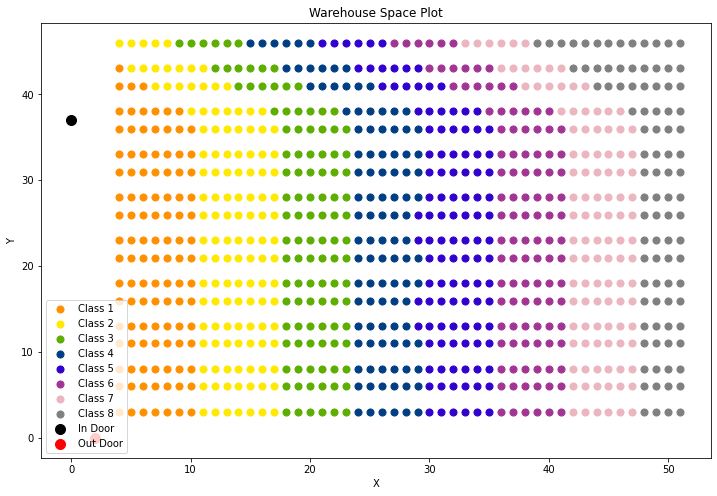

In [23]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Set the coordinate for in_door and out_door
in_door = (0, 37)
out_door = (2, 0)

# Set an array to collect all spaces that forklift needs to move to
spaces = []
for row in range(1, 48):
    if row % 5 != 0:
        continue
    for col in range(0, 54):
        if col < 4 or col > 51:
            continue

        x = col
        y_even = row + 1
        y_odd = row - 2

        spaces.append((x, y_odd))
        spaces.append((x, y_even))

# Calculate the distance that forklift needs to move to
distances = []
for space in spaces:
    dist_to_in_door = abs(space[0] - in_door[0]) * (73.125 / 54) + abs(space[1] - in_door[1]) * (65 / 48)
    dist_to_out_door = abs(space[0] - out_door[0]) * (73.125 / 54) + abs(space[1] - out_door[1]) * (65 / 48)
    total_dist = dist_to_in_door + dist_to_out_door
    distances.append((space, total_dist))

# Sort the distances
distances.sort(key=lambda x: x[1])

# And then divide it into 8 classes by percentile
dist_values = [x[1] for x in distances]
percentiles = np.percentile(dist_values, [12.5, 25, 37.5, 50, 62.5, 75, 87.5])
class1 = [x[0] for x in distances if x[1] <= percentiles[0]]
class2 = [x[0] for x in distances if percentiles[0] < x[1] <= percentiles[1]]
class3 = [x[0] for x in distances if percentiles[1] < x[1] <= percentiles[2]]
class4 = [x[0] for x in distances if percentiles[2] < x[1] <= percentiles[3]]
class5 = [x[0] for x in distances if percentiles[3] < x[1] <= percentiles[4]]
class6 = [x[0] for x in distances if percentiles[4] < x[1] <= percentiles[5]]
class7 = [x[0] for x in distances if percentiles[5] < x[1] <= percentiles[6]]
class8 = [x[0] for x in distances if x[1] > percentiles[6]]

# Define the colors for the classes using gradient colormap
cmap = colors.LinearSegmentedColormap.from_list("", ["red", "orange", "yellow", "green", "blue", "purple", "pink", "gray"])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the spaces
ax.scatter([space[0] for space in class1], [space[1] for space in class1], color=cmap(1/8), label='Class 1', s=50)
ax.scatter([space[0] for space in class2], [space[1] for space in class2], color=cmap(2/8), label='Class 2', s=50)
ax.scatter([space[0] for space in class3], [space[1] for space in class3], color=cmap(3/8), label='Class 3', s=50)
ax.scatter([space[0] for space in class4], [space[1] for space in class4], color=cmap(4/8), label='Class 4', s=50)
ax.scatter([space[0] for space in class5], [space[1] for space in class5], color=cmap(5/8), label='Class 5', s=50)
ax.scatter([space[0] for space in class6], [space[1] for space in class6], color=cmap(6/8), label='Class 6', s=50)
ax.scatter([space[0] for space in class7], [space[1] for space in class7], color=cmap(7/8), label='Class 7', s=50)
ax.scatter([space[0] for space in class8], [space[1] for space in class8], color=cmap(8/8), label='Class 8', s=50)

# Plot the in_door and out_door
ax.scatter(in_door[0], in_door[1], color='black', label='In Door', s=100)
ax.scatter(out_door[0], out_door[1], color='red', label='Out Door', s=100)

# Set the title and labels
ax.set_title('Warehouse Space Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Add the legend
ax.legend()

# Show the plot
plt.show()

#### **3.2 Calculate the distance from class to in-door and out-door**

we use average distance to estimate s_j & r_j for 8 classes in each

In [ ]:
# calculate average distance to in_door and out_door for each class
class_distances = [class1, class2, class3, class4,class5, class6, class7, class8]

avg_distances = np.zeros((8, 2))  # create a matrix of zeros with shape (8, 2)

for i in range(8):
    distances = class_distances[i]
    total_dist_in = 0
    total_dist_out = 0
    for space in distances:
        dist_to_in_door = abs(space[0] - in_door[0])*(73.125/54) + abs(space[1] - in_door[1])*(65/48)
        dist_to_out_door = abs(space[0] - out_door[0])*(73.125/54) + abs(space[1] - out_door[1])*(65/48)
        total_dist_in += dist_to_in_door
        total_dist_out += dist_to_out_door
    avg_dist_in = total_dist_in / len(distances)
    avg_dist_out = total_dist_out / len(distances)
    avg_distances[i, 0] = avg_dist_in  # assign the average distances to the matrix
    avg_distances[i, 1] = avg_dist_out

print(avg_distances)

[[ 31.13329475  35.52179784]
 [ 37.74193548  47.67977151]
 [ 46.19212963  56.72453704]
 [ 53.984375    64.921875  ]
 [ 62.4609375   72.6171875 ]
 [ 70.56712963  81.09953704]
 [ 78.69212963  89.22453704]
 [ 83.03102355 101.5772192 ]]


In [ ]:
# extract the first column as s
# extract the second column as r
s_j = avg_distances[:, 0]
r_j = avg_distances[:, 1]
# print s_j
print(s_j)
print(r_j)

[31.13329475 37.74193548 46.19212963 53.984375   62.4609375  70.56712963
 78.69212963 83.03102355]
[ 35.52179784  47.67977151  56.72453704  64.921875    72.6171875
  81.09953704  89.22453704 101.5772192 ]


#### **3.3 Calculate the capacity for 8 classes in each:**

we calculare the capacity based on the number of section in each classes and the number of level in each tracks in the warehouse.

the result is shown as below:

In [ ]:
import pandas as pd
Capacity = [502,566,	492,	472,	512,	492,	492	,408]
Class = [1,2,3,4,5,6,7,8]
Capacity_8class = pd.DataFrame({'Class': Class, 'Capacity': Capacity})

print(Capacity_8class)

   Class  Capacity
0      1       502
1      2       566
2      3       492
3      4       472
4      5       512
5      6       492
6      7       492
7      8       408


### **3.4 Evaluate the preformance of LPM method if increasing N**

**Result : Average weekly travel distance for LPM policy is 62642.01** （这是全部的，如果要用前三周算 average需要换一下）

Detailed calculation is shown as below:

In [ ]:
!pip install pulp
import pulp

N = 8
M = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12]

result_list = []  # create an empty list to store the objective function values

for k in range(18, 52):
    T = [6 * k + 1, 6 * k + 2, 6 * k + 3, 6 * k + 4, 6 * k + 5, 6 * k + 6]

    c_j = [502, 566, 492, 472, 512, 492, 492, 408]

    problem = LpProblem("Warehouse_Optimization", LpMinimize)

    v = LpVariable.dicts("v", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
    w = LpVariable.dicts("w", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
    x = LpVariable.dicts("x", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")

    problem += lpSum(s_j[j] * v[i, j, t] + r_j[j] * w[i, j, t] for i in M for j in range(N) for t in T)

    for i in M:
        for t in T:
            problem += lpSum(v[i, j, t] for j in range(N)) == a_it[i][t]
            problem += lpSum(w[i, j, t] for j in range(N)) == d_it[i][t]

    for i in M:
        for j in range(N):
            for t in T[:-1]:
                problem += v[i, j, t] - w[i, j, t] + x[i, j, t] == x[i, j, t + 1]

    for j in range(N):
        for t in T:
            problem += lpSum(x[i, j, t] + v[i, j, t] for i in M) <= c_j[j]

    problem.solve()

    result_list.append(value(problem.objective))  # append the objective function value to the list

    print(f"Status week{k}: {LpStatus[problem.status]}")
    print("Optimal Solution:", value(problem.objective))

mean_result = sum(result_list) / len(result_list)  # calculate the mean of the objective function values

print(f"Mean of objective function values: {mean_result}")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Status week18: Optimal
Optimal Solution: 63346.057887980416
Status week19: Optimal
Optimal Solution: 64236.237534806656
Status week20: Optimal
Optimal Solution: 65120.85067393173
Status week21: Optimal
Optimal Solution: 65314.205369252
Status week22: Optimal
Optimal Solution: 66622.01885807041
Status week23: Optimal
Optimal Solution: 65682.6528890951
Status week24: Optimal
Optimal Solution: 65240.32528957113
Status week25: Optimal
Optimal Solution: 64279.72709200866
Status week26: Optimal
Optimal Solution: 63689.76525561984
Status week27: Optimal
Optimal Solution: 65656.18874675501
Status week28: Optimal
Optimal Solution: 66411.3550057249
Status week29: Optimal
Optimal Solution: 66725.52625959596
Status week30: Optimal
Optimal Solution: 65598.71874183555
Status week31: Optimal
Optimal Solution: 65039.08826334086
Status week32: Optimal
Optimal Solution: 65356.316991010994
Status week33: Op

In [ ]:

mean_result = sum(result_list[:3]) / 3  # calculate the mean of the first three objective function values

print(f"Mean of the first three objective function values: {mean_result}")

Mean of the first three objective function values: 64234.382032239606


## **Question 4 ：For Ouestion (2), what was the performance of each policy if the number of products M increased?**

**Answer**

Based on our calculation shown below, increasing the number of Product M would increase the travel distance of the policy.(eg. when M is increased from 10 to 15, Average weekly travel distance for LPM policy is increased from 60791.48 to 81165.67)

### **we increase M from 10 to 15**

**4.1 Calculate flow rate to select Top 15 product**

I calculate the flow amount for the first 16 weeks to pick up the **top 15** product (we need to predict later) that has the largest flow amount. And use these 15 products to forecast the optimized distance.

In [ ]:
#Then merge two xlsx files using outer join on 'day' and 'product'
df_merged = pd.merge(df_inbound, df_outbound, on=['day', 'product'], how='outer')

# Fill NaN values with 0
df_merged.fillna(0, inplace=True)

# Sort the merged dataframe by 'day' and 'product'
df_merged.sort_values(['day', 'product'], inplace=True)

# Reset the index
df_merged.reset_index(drop=True, inplace=True)

# group the data by day and product, and calculate the sum of inbound and outbound amounts
df_flow = df_merged.groupby(['day', 'product'])['inbound', 'outbound'].sum()

# calculate the flow amount by adding inbound and outbound amounts
df_flow['flow_amount'] = df_flow['inbound'] + df_flow['outbound']

# filter the data for the first 16 weeks
df_flow_16weeks = df_flow[df_flow.index.get_level_values('day') <= 96]

# calculate the average flow amount for each product and sort by descending order
df_ranked = df_flow_16weeks.groupby('product')['flow_amount'].sum().sort_values(ascending=False)
df_ranked.head(15)

<ipython-input-143-d05e509a5fea>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_flow = df_merged.groupby(['day', 'product'])['inbound', 'outbound'].sum()


product
1     3315.0
3     1423.0
2     1339.0
4     1271.0
9     1106.0
5     1030.0
7     1015.0
10     968.0
11     919.0
12     904.0
8      861.0
16     861.0
14     821.0
6      717.0
13     630.0
Name: flow_amount, dtype: float64

Here, we can see the top 10 flow amount products are 1,3,2,4,9,5,7,10,11,12,8,16,14,6,13

In [ ]:
desired_products = [1, 3, 2, 4, 9, 5, 7, 10, 11, 12,8,16,14,6,13]
filtered_data15 = df_merged[df_merged['product'].isin(desired_products)]

**4.2 Estimate the minimum initial inventory for Top 15 prodcut**

In [ ]:
filtered_data15 = df_merged[df_merged['product'].isin(desired_products)].copy()
# Calculate the cumulative sum of inbound and outbound for each product
filtered_data15['cum_inbound'] = filtered_data15.groupby('product')['inbound'].cumsum()
filtered_data15['cum_outbound'] = filtered_data15.groupby('product')['outbound'].cumsum()

# Calculate the difference between cumulative inbound and outbound
filtered_data15['difference'] = filtered_data15['cum_inbound'] - filtered_data15['cum_outbound']

# Find the minimum difference for each product
min_difference = filtered_data15.groupby('product')['difference'].min().reset_index()

# If the minimum difference is negative, take its absolute value as the minimum initial inventory required
min_difference['min_initial_inventory'] = min_difference['difference'].apply(lambda x: abs(x) if x < 0 else 0)

print(min_difference[['product', 'min_initial_inventory']])

    product  min_initial_inventory
0         1                  115.0
1         2                  188.0
2         3                 4035.0
3         4                    0.0
4         5                  245.0
5         6                 1818.0
6         7                 3022.0
7         8                    0.0
8         9                    0.0
9        10                 2590.0
10       11                    0.0
11       12                 2657.0
12       13                    1.0
13       14                 2526.0
14       16                  108.0


**4.3 Using Moving Average to forecast demand**

In [ ]:
df_merged_desired = df_merged[df_merged['product'].isin(desired_products)].copy()
df_merged_desired_16weeks = df_merged_desired[df_merged_desired['day']<=96]

In [ ]:
all_results = []
for i in range (17,52):
  start_day = i*6 +1
  end_day = i*6 +6
  moving_average_days = 96

  filtered_df = df_merged_desired[df_merged_desired['product'].isin(products_to_select)].copy()

  filtered_df['inbound_ma'] = filtered_df.groupby('product')['inbound'].transform(lambda x: x.rolling(window=moving_average_days, min_periods=1).mean())
  filtered_df['outbound_ma'] = filtered_df.groupby('product')['outbound'].transform(lambda x: x.rolling(window=moving_average_days, min_periods=1).mean())

  results = []
  for product in products_to_select:
      product_data = filtered_df[filtered_df['product'] == product]

      for day in range(start_day, end_day + 1):
          lower_bound = day - 96
          upper_bound = day - 1
          product_data_filtered = product_data[(product_data['day'] >= lower_bound) & (product_data['day'] <= upper_bound)]

          average_inbound = product_data_filtered['inbound'].mean()
          average_outbound = product_data_filtered['outbound'].mean()
          results.append({'day': day, 'product': product, 'inbound': average_inbound,'outbound': average_outbound})

  result_df = pd.DataFrame(results)
  all_results.append(result_df)

final_result_df = pd.concat(all_results, ignore_index=True)
#print(final_result_df)

concatenated_df = pd.concat([df_merged_desired_16weeks, final_result_df], ignore_index=True)
print(concatenated_df)

      day  product  inbound   outbound
0       1        1     18.0   0.000000
1       1        3      0.0  10.000000
2       1        4      1.0   0.000000
3       1        5     55.0   0.000000
4       1        7     17.0  10.000000
...   ...      ...      ...        ...
2883  308       12      0.0  11.344262
2884  309       12      0.0  11.344262
2885  310       12      0.0  11.344262
2886  311       12      0.0  11.433333
2887  312       12      0.0  11.423729

[2888 rows x 4 columns]


**4.4 Preformance of LPM if increasing M**


**Result : Average weekly travel distance for LPM policy is 81165.67** 

Detailed calculation is shown as below:

In [ ]:
# Create an empty numpy array to store the values of a_it
a_it = np.zeros((20, 313))
d_it = np.zeros((20, 313))

# Loop through each product and day and get the corresponding value of a_it
for i in range(20):
    for t in range(97,313):
        day = t
        if i in concatenated_df['product'].values:
            inbound_values = concatenated_df.loc[(concatenated_df['product'] == i) & (concatenated_df['day'] == day), 'inbound'].values
            if len(inbound_values) > 0:
                a_it[i][t] = inbound_values[0]
            else:
                a_it[i][t] = 0
        else:
            a_it[i][t] = 0
        

for i in range(20):
    for t in range(97,313):
        day = t
        if i in concatenated_df['product'].values:
            outbound_values = concatenated_df.loc[(concatenated_df['product'] == i) & (concatenated_df['day'] == day), 'outbound'].values
            if len(outbound_values) > 0:
                d_it[i][t] = outbound_values[0]
            else:
                d_it[i][t] = 0
        else:
            d_it[i][t] = 0

In [ ]:
!pip install pulp
import pulp

N = 4
M = desired_products

result_list = []

for k in range(18,52):
#M = products_to_select

  T = [6*k+1, 6*k+2, 6*k+3, 6*k+4, 6*k+5, 6*k+6]

  # capacity c
  c_j = [1068, 964, 1004, 900]

  # Define the problem
  problem = pulp.LpProblem("Warehouse_Optimization", pulp.LpMinimize)

  # Define decision variables
  v = pulp.LpVariable.dicts("v", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
  w = pulp.LpVariable.dicts("w", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")
  x = pulp.LpVariable.dicts("x", ((i, j, t) for i in M for j in range(N) for t in T), lowBound=0, cat="Continuous")

  # Define objective function
  problem += pulp.lpSum(s_j[j] * v[i, j, t] + r_j[j] * w[i, j, t] for i in M for j in range(N) for t in T)

  # Add constraints
  for i in M:
      for t in T:
          problem += pulp.lpSum(v[i, j, t] for j in range(N)) == a_it[i][t]  # constraint 1
          problem += pulp.lpSum(w[i, j, t] for j in range(N)) == d_it[i][t]  # constraint 2

  for i in M:
      for j in range(N):
          for t in T[:-1]:
              problem += v[i, j, t] - w[i, j, t] + x[i, j, t] == x[i, j, t + 1]  # constraint 3

  for j in range(N):
      for t in T:
          problem += pulp.lpSum(x[i, j, t] + v[i, j, t] for i in M) <= c_j[j]  # constraint 4

  # Solve the problem
  problem.solve()

  result_list.append(value(problem.objective))

  # Print the results
  print(f"Status week{k}: {pulp.LpStatus[problem.status]}")
  print("Optimal Solution:", pulp.value(problem.objective))

mean_result = sum(result_list) / len(result_list)

print(f"Mean of objective function values: {mean_result}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Status week18: Optimal
Optimal Solution: 70279.3494125498
Status week19: Optimal
Optimal Solution: 71231.07365518477
Status week20: Optimal
Optimal Solution: 72079.53503147647
Status week21: Optimal
Optimal Solution: 72237.13779395743
Status week22: Optimal
Optimal Solution: 73503.02127142002
Status week23: Optimal
Optimal Solution: 72674.66147851705
Status week24: Optimal
Optimal Solution: 72366.0865585815
Status week25: Optimal
Optimal Solution: 71600.08370586905
Status week26: Optimal
Optimal Solution: 71199.8336863832
Status week27: Optimal
Optimal Solution: 73136.68001496163
Status week28: Optimal
Optimal Solution: 73877.82756154954
Status week29: Optimal
Optimal Solution: 74110.78349899521
Status week30: Optimal
Optimal Solution: 73188.8272334551
Status week31: Optimal
Optimal Solution: 72741.61509082222
Status week32: Optimal
Optimal Solution: 72966.75483763272
Status week33: Optim